In [1]:
from tsai.models import InceptionTime, TST, ResNet
# from tsai.data.core import get_UCR_data
# from tsai.learner import TSClassifier
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, results_path
from preprocessing_modules import create_time_windows_with_labels, create_time_windows_with_metadata
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")
from fastai.data.core import DataLoaders
import csv

from fastai.optimizer import SGD, Adam


/home/nwertheim/miniconda3/bin/python


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc
wandb: Currently logged in as: noorwertheim to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Final Hyperparameters for each subset
batch_size = 16
learning_rate = 7.007288273635997e-07
optimizer_name = 'Adam' # or 'SGD'
data_subset = 20 # choose: 20, 40, 60, 80, 100

opt_func_map = {
'SGD': SGD,
'Adam': Adam,
}
opt_func = opt_func_map[optimizer_name]

In [3]:
results_csv_path = os.path.join(results_path, "resnet_subset_runs.csv")

if not os.path.isfile(results_csv_path):
    with open(results_csv_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "run",
            "data_subset",
            "accuracy",
            "precision",
            "recall",
            "f1",
            "average_precision",
            "roc_auc"
        ])

In [4]:

'''MY DATA + class weights'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train_2_" + str(data_subset) + ".npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test_2.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import SGD
from torch.optim import AdamW
from functools import partial
from fastai.optimizer import OptimWrapper
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.core import DataLoaders



from collections import Counter

train_windows, train_labels, train_meta = create_time_windows_with_metadata(train_data)
test_windows, test_labels, test_meta = create_time_windows_with_metadata(test_data)

# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Test metadata for reference
test_meta = test_meta
print('batch size', batch_size)
dls = DataLoaders(train_loader, test_loader)


# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

148
192
{'record_name': 'Hopper-2022_02_08_15_07_31-0000010181-0011-chan3', 'signal': array([[14.23043527],
       [24.57069717],
       [17.99612535],
       ...,
       [-1.21857878],
       [ 0.82743019],
       [-2.60873858]]), 'fs': 20, 'preterm': 1}
torch.Size([1806])
batch size 16


In [5]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, roc_auc_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tsai.models.ResNet import ResNet
from fastai.learner import Learner
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch
from fastai.optimizer import SGD
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback


# Fix seeds for reproducibility
def seed_everything(seed):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
num_epochs = 10
num_runs = 5
all_train_losses = []
all_valid_losses = []
all_metrics = []

best_ap = -1
best_preds = None
best_targs = None

all_pred_labels = []
all_pred_probs = []


for run in range(num_runs):
    print(f"\n🌀 Run {run+1}/{num_runs}")

    wandb.init(
        project=f"resnet{data_subset}",
        name=f"resnet_run_{run+1}",
        config={
            "architecture": "ResNet",
            "epochs": num_epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "run": run + 1
        }
    )
    seed_everything(run)

    # Model
    model = ResNet(1, 2).to(device)

    # Loss with class weights
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    loss_func = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Learner
    learn = Learner(
        dls,
        model,
        loss_func=loss_func,
        opt_func = opt_func,
        metrics=accuracy,
        cbs=[
            EarlyStoppingCallback(monitor='valid_loss', patience=3),
            SaveModelCallback(monitor='valid_loss', fname=f'best_resnet_run_{run}'),
            WandbCallback(log='all', log_model=True, log_preds=True)
        ]
    )
    # test

    learn.model.to(device)

    # no weight decay
    learn.fit_one_cycle(num_epochs, learning_rate)    

    # Record losses
    losses = np.array(learn.recorder.losses)
    iters_per_epoch = len(train_loader)
    train_loss = losses[::2][:num_epochs]
    valid_loss = losses[1::2][:num_epochs]
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)

    # Get predictions
    preds, targs = learn.get_preds(dl=learn.dls.valid)
    pred_labels = preds.argmax(dim=1)
    pred_probs = preds[:, 1].cpu().numpy()
    true_labels = targs.cpu().numpy()
    pred_labels_np = pred_labels.cpu().numpy()
    all_pred_labels.append(pred_labels_np)  # shape (n_samples,)
    all_pred_probs.append(pred_probs)       # shape (n_samples,)


    # Calculate metrics
    acc = accuracy_score(true_labels, pred_labels_np)
    prec = precision_score(true_labels, pred_labels_np, zero_division=0)
    rec = recall_score(true_labels, pred_labels_np, zero_division=0)
    f1 = f1_score(true_labels, pred_labels_np, zero_division=0)
    ap = average_precision_score(true_labels, pred_probs)
    auc = roc_auc_score(true_labels, pred_probs)
    all_metrics.append([acc, prec, rec, f1, ap, auc])

    # Write results to CSV
    with open(results_csv_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([run + 1, data_subset, acc, prec, rec, f1, ap, auc])

    wandb.log({
        "final_accuracy": acc,
        "final_precision": prec,
        "final_recall": rec,
        "final_f1": f1,
        "final_average_precision": ap,
        "final_auc": auc
    })

    wandb.finish()

    if ap > best_ap:
        best_ap = ap
        best_preds = preds
        best_targs = true_labels

    

# Convert to arrays for easy processing
all_train_losses = np.stack(all_train_losses)
all_valid_losses = np.stack(all_valid_losses)
all_metrics = np.stack(all_metrics)



🌀 Run 1/5


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.700446,0.703376,0.359896,00:04
1,0.696958,0.690788,0.339583,00:04
2,0.697172,0.686779,0.572396,00:04
3,0.693132,0.678724,0.667188,00:04
4,0.689885,0.678434,0.672396,00:04
5,0.687775,0.674740,0.704167,00:04
6,0.688032,0.672598,0.674479,00:04
7,0.685405,0.679104,0.644271,00:04
8,0.687581,0.672446,0.662500,00:04
9,0.690696,0.670810,0.677083,00:04


Better model found at epoch 0 with valid_loss value: 0.703375518321991.
Better model found at epoch 1 with valid_loss value: 0.6907882690429688.
Better model found at epoch 2 with valid_loss value: 0.6867787837982178.
Better model found at epoch 3 with valid_loss value: 0.6787240505218506.
Better model found at epoch 4 with valid_loss value: 0.6784335970878601.
Better model found at epoch 5 with valid_loss value: 0.6747398972511292.
Better model found at epoch 6 with valid_loss value: 0.6725984811782837.
Better model found at epoch 8 with valid_loss value: 0.67244553565979.
Better model found at epoch 9 with valid_loss value: 0.6708104014396667.


accuracy,▁▁▅▇▇█▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▂▂▂▃▃▅▅▆▇██████▇▇▇▇▇▅▅▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▁▁▁
mom_0,█▇▇▆▆▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇███



🌀 Run 2/5


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.704233,0.739582,0.447396,00:04
1,0.698307,0.729272,0.502604,00:04
2,0.695616,0.709026,0.536458,00:04
3,0.694539,0.699074,0.545833,00:04
4,0.687048,0.688448,0.614583,00:04
5,0.685113,0.684436,0.623958,00:04
6,0.685392,0.692711,0.559375,00:04
7,0.681841,0.690988,0.549479,00:04
8,0.684100,0.677083,0.644271,00:04
9,0.684569,0.676964,0.645833,00:04


Better model found at epoch 0 with valid_loss value: 0.7395821809768677.
Better model found at epoch 1 with valid_loss value: 0.7292719483375549.
Better model found at epoch 2 with valid_loss value: 0.7090258002281189.
Better model found at epoch 3 with valid_loss value: 0.6990741491317749.
Better model found at epoch 4 with valid_loss value: 0.6884483098983765.
Better model found at epoch 5 with valid_loss value: 0.6844358444213867.
Better model found at epoch 8 with valid_loss value: 0.6770829558372498.
Better model found at epoch 9 with valid_loss value: 0.6769639849662781.


accuracy,▁▃▄▄▇▇▅▅██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▂▂▃▅▆▆██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁
mom_0,██▇▇▇▄▂▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇████



🌀 Run 3/5


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.716147,0.764254,0.212500,00:04
1,0.716739,0.769352,0.212500,00:04
2,0.700760,0.739205,0.212500,00:04
3,0.700912,0.744553,0.212500,00:04
4,0.695330,0.723206,0.228646,00:04
5,0.696572,0.715701,0.368229,00:04
6,0.692479,0.713842,0.416146,00:04
7,0.688736,0.717236,0.367188,00:04
8,0.691767,0.719348,0.351562,00:04
9,0.691891,0.715471,0.356771,00:04


Better model found at epoch 0 with valid_loss value: 0.7642543911933899.
Better model found at epoch 2 with valid_loss value: 0.7392053604125977.
Better model found at epoch 4 with valid_loss value: 0.7232056856155396.
Better model found at epoch 5 with valid_loss value: 0.7157014608383179.
Better model found at epoch 6 with valid_loss value: 0.7138422131538391.
No improvement since epoch 6: early stopping


accuracy,▁▁▁▁▂▆█▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▂▂▂▂▂▃▃▄▄▅▅▆███████▇▇▇▆▅▅▅▄▃▃▂▂▂▂▁▁▁▁
mom_0,█▇▄▃▂▁▁▁▁▁▂▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████



🌀 Run 4/5


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.740629,0.828072,0.212500,00:04
1,0.735351,0.811724,0.212500,00:04
2,0.719356,0.772582,0.212500,00:04
3,0.714746,0.767074,0.212500,00:04
4,0.702296,0.765889,0.212500,00:04
5,0.697498,0.742056,0.212500,00:04
6,0.696275,0.727443,0.212500,00:04
7,0.696032,0.729506,0.212500,00:04
8,0.692710,0.736433,0.212500,00:04
9,0.694384,0.736977,0.212500,00:04


Better model found at epoch 0 with valid_loss value: 0.8280717134475708.
Better model found at epoch 1 with valid_loss value: 0.811723530292511.
Better model found at epoch 2 with valid_loss value: 0.7725823521614075.
Better model found at epoch 3 with valid_loss value: 0.7670741677284241.
Better model found at epoch 4 with valid_loss value: 0.7658892869949341.
Better model found at epoch 5 with valid_loss value: 0.7420563101768494.
Better model found at epoch 6 with valid_loss value: 0.7274433374404907.
No improvement since epoch 6: early stopping


accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▂▃▄▄▅█████▇▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▆▆▆▆▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▇▇█████████



🌀 Run 5/5


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.725857,0.727735,0.629687,00:04
1,0.721958,0.744632,0.502604,00:04
2,0.710662,0.731753,0.478125,00:04
3,0.702491,0.717871,0.447917,00:04
4,0.697542,0.703996,0.464583,00:04
5,0.691834,0.703898,0.441146,00:04
6,0.692271,0.698640,0.472917,00:04
7,0.693529,0.696187,0.502604,00:04
8,0.686741,0.703696,0.463542,00:04
9,0.687383,0.692773,0.511458,00:04


Better model found at epoch 0 with valid_loss value: 0.7277353405952454.
Better model found at epoch 3 with valid_loss value: 0.7178712487220764.
Better model found at epoch 4 with valid_loss value: 0.7039957642555237.
Better model found at epoch 5 with valid_loss value: 0.7038976550102234.
Better model found at epoch 6 with valid_loss value: 0.6986404657363892.
Better model found at epoch 7 with valid_loss value: 0.6961867213249207.
Better model found at epoch 9 with valid_loss value: 0.6927732229232788.


accuracy,█▃▂▁▂▁▂▃▂▄
epoch,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▂▂▂▃▃▅▅▆▇▇███████▇▇▇▆▆▆▆▆▆▆▆▅▄▃▂▂▂▂▂▂▁▁▁
mom_0,██▇▆▅▃▃▂▂▁▁▁▁▁▂▂▂▂▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██████


In [6]:
# preds, targs = learn.get_preds(dl=test_loader)

print(best_preds)
# For multi-class classification, select the class with the highest probability
pred_labels = best_preds.argmax(dim=1).numpy()  # Get the class label with the highest probability
pred_probs = torch.softmax(best_preds, dim=1)[:, 1].cpu().numpy()  # now each row sums to 1
print(pred_probs)
# Convert true labels to numpy array
# best_targs = best_targs.numpy()

# Ensure lengths match
print(len(pred_labels), len(targs), len(test_meta))

# Create the DataFrame
window_ids = [entry['record_name'] + '-' + str(entry['window_index']) for entry in test_meta]
final_df = pd.DataFrame({
    'window_id': window_ids,
    'best_pred_label': pred_labels,  # Save class labels instead of probabilities
    'best_pred_prob': pred_probs,
    'target': best_targs
})

#  Add predictions from each run
for run_idx, (labels, probs) in enumerate(zip(all_pred_labels, all_pred_probs), start=1):
    final_df[f'pred_label{run_idx}'] = labels
    final_df[f'pred_prob{run_idx}'] = probs

# Save to CSV
final_df.to_csv("results_ResNet_SGD_all_runs.csv", index=False)



tensor([[-0.1027, -0.1654],
        [-0.1309, -0.1420],
        [-0.0988, -0.1640],
        ...,
        [-0.0579, -0.1768],
        [-0.0091, -0.1827],
        [ 0.0303, -0.1872]])
[0.4843312  0.4972282  0.48370796 ... 0.4703082  0.45669085 0.445837  ]
1920 1920 1920


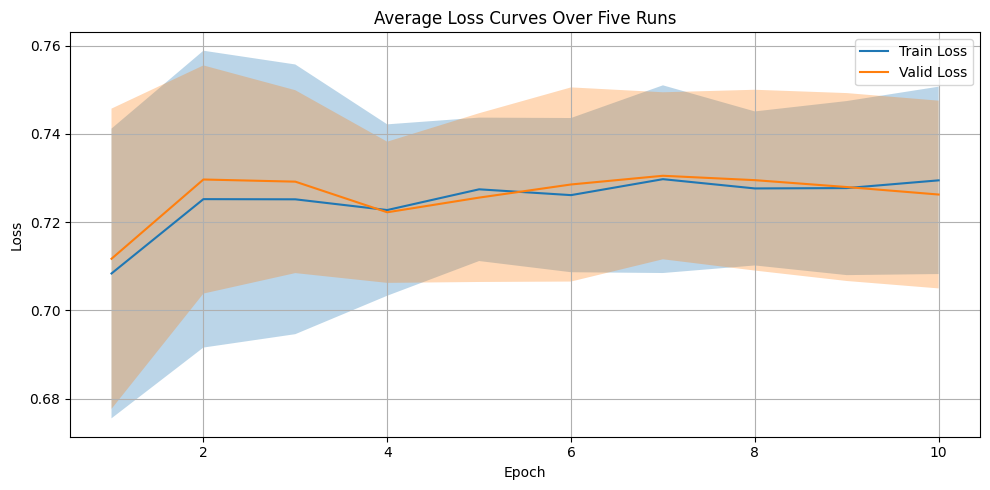

In [7]:
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(10, 5))

# Train loss
mean_train = all_train_losses.mean(axis=0)
std_train = all_train_losses.std(axis=0)
plt.plot(epochs, mean_train, label='Train Loss')
plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.3)

# Valid loss
mean_valid = all_valid_losses.mean(axis=0)
std_valid = all_valid_losses.std(axis=0)
plt.plot(epochs, mean_valid, label='Valid Loss')
plt.fill_between(epochs, mean_valid - std_valid, mean_valid + std_valid, alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curves Over Five Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy: 0.4926 ± 0.1686
Precision: 0.7550 ± 0.3789
Recall: 0.3840 ± 0.2400
F1 Score: 0.4931 ± 0.2762
AP: 0.8894 ± 0.0707
AUC: 0.6905 ± 0.1134


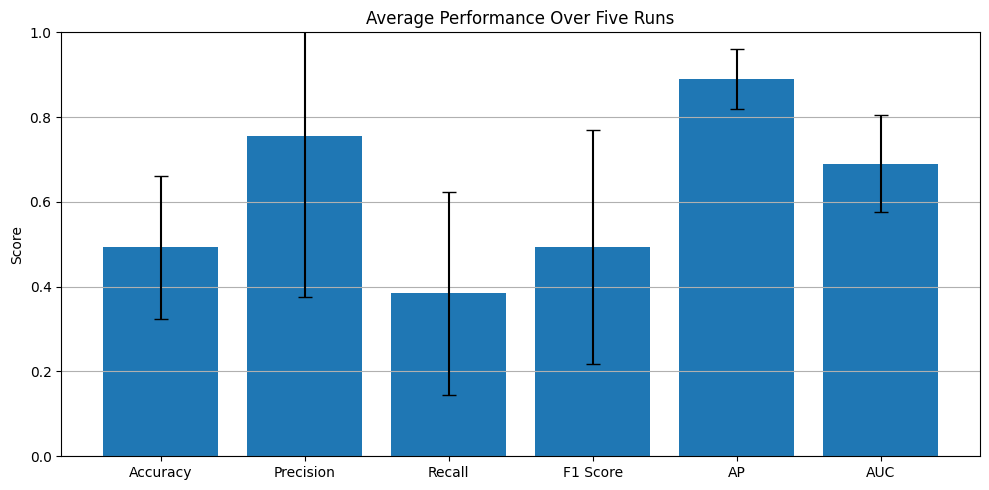

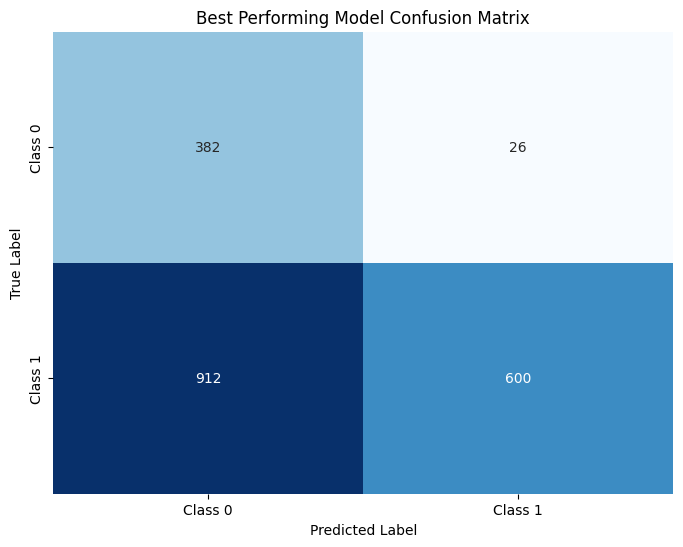

In [8]:
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AP', 'AUC']
mean_metrics = all_metrics.mean(axis=0)
std_metrics = all_metrics.std(axis=0)

for name, mean, std in zip(metric_names, mean_metrics, std_metrics):
    print(f"{name}: {mean:.4f} ± {std:.4f}")

# Bar plot
plt.figure(figsize=(10, 5))
plt.bar(metric_names, mean_metrics, yerr=std_metrics, capsize=5)
plt.title('Average Performance Over Five Runs')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

cm = confusion_matrix(best_targs, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Best Performing Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
